In [ ]:
!wget http://commachallenge.s3-us-west-2.amazonaws.com/speed_challenge_2017.tar

In [ ]:
!wget https://raw.githubusercontent.com/justinglibert/speed-challenge/master/model.py
!wget https://raw.githubusercontent.com/justinglibert/speed-challenge/master/processing.py

In [14]:
!pip install sk-video

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
# coding: utf-8
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
from model import build_model
import matplotlib.pyplot as plt
import processing
from sklearn.metrics import mean_squared_error
from model import build_model
import os
import pandas as pd
from pandas import Series
import pickle
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

import csv
import skvideo.io
from processing import process
from multiprocessing import Lock

In [18]:
def prepare_dataset(video_path, frame_folder, flow_folder, name, speeds=None):
    tqdm.set_lock(Lock())  # manually set internal lock
    #Step 1, Extract frames and speed
    dataframe_dict = {}
    if not os.path.exists(frame_folder):
        os.makedirs(frame_folder)
    print("Reading the video file")
    video_sk = skvideo.io.vread(video_path)
    print("Extracting the frames")
    for index, frame in enumerate(tqdm(video_sk)):    
        saving_path = os.path.join(frame_folder, str(index)+'.jpg')
        if speeds is None:
            speed = 0
        else:
            speed = speeds[index]
        dataframe_dict[index] = [saving_path, index, speed]
        skvideo.io.vwrite(saving_path, frame)
    
    processed_dataframe = pd.DataFrame.from_dict(dataframe_dict, orient='index')
    processed_dataframe.columns = ['frame_path', 'frame_index', 'speed']
    print("Saving the dataframe")
    processed_dataframe.to_csv(os.path.join(PREPARED_DATA_PATH, name +'_meta.csv'), index=False)
    #Step 2, compute optical flow between frames and average the speed
    flow_dict = {}
    if not os.path.exists(flow_folder):
        os.makedirs(flow_folder)
    print("Computing the optical flow")
    for index in tqdm(range(len(processed_dataframe ) - 1)):
        idx1 = index
        idx2 = index + 1
        frame1 = processed_dataframe.iloc[[idx1]]
        frame2 = processed_dataframe.iloc[[idx2]]

        assert(frame2['frame_index'].values[0] - frame1['frame_index'].values[0] == 1)
        assert(frame2['frame_index'].values[0] > frame1['frame_index'].values[0])

        frame1_path = frame1['frame_path'].values[0]
        frame1_speed = frame1['speed'].values[0]
        frame2_path = frame2['frame_path'].values[0]
        frame2_speed = frame2['speed'].values[0]

        flow = process(frame1_path, frame2_path, SIZE)

        flow_path = os.path.join(flow_folder, str(index) + '.png') 

        cv2.imwrite(flow_path, flow)

        speed = np.mean([frame1_speed, frame2_speed]) 
        flow_dict[index] = [flow_path, speed]

    flow_dataframe = pd.DataFrame.from_dict(flow_dict, orient='index')
    flow_dataframe.columns = ['flow_path', 'speed']
    print("Saving the flow dataframe")
    flow_dataframe.to_csv(os.path.join(PREPARED_DATA_PATH, name +'_flow_meta.csv'), index=False)

In [ ]:
speeds_train = list(pd.read_csv(os.path.join(DATA_PATH, 'train.txt'), header=None, squeeze=True))
print("==Processing Train==")
prepare_dataset(TRAIN_VIDEO, PREPARED_IMGS_TRAIN, FLOW_IMGS_TRAIN, 'train', speeds_train)
print("==Processing Test==")
prepare_dataset(TEST_VIDEO, PREPARED_IMGS_TEST, FLOW_IMGS_TEST, 'test')

In [26]:
if '__file__' not in globals():
    CURRENT_DIR = os.getcwd()
else:
    CURRENT_DIR = os.path.dirname(os.path.realpath(__file__))

SAVES = os.path.join(CURRENT_DIR, 'saves')

DATA_PATH =  os.path.join(CURRENT_DIR, 'data')
PREPARED_DATA_PATH = os.path.join(DATA_PATH, 'prepared-data')

FLOW_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'flow_train_imgs')
TRAIN_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'train_flow_meta.csv')
FLOW_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'flow_test_imgs')

TEST_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_flow_meta.csv')
TEST_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_meta.csv')
TEST_TEXT_PATH = os.path.join(DATA_PATH, 'test.txt')

SIZE = (100, 100)
CHANNEL = 2

WIDTH = SIZE[0]
HEIGHT = SIZE[1]

In [27]:
MINI_BATCH_SIZE = 32
EPOCHS = 100
VERSION = 5

LEARNING_RATE = 0.001

In [28]:
TRAIN_VIDEO = os.path.join(DATA_PATH, 'train.mp4')
TEST_VIDEO = os.path.join(DATA_PATH, 'test.mp4')

PREPARED_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'train_imgs')
PREPARED_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'test_imgs')

MODEL_SAVE_PATH = os.path.join(CURRENT_DIR, 'saves', str(VERSION), str(EPOCHS), str(LEARNING_RATE))
WEIGHTS_PATH = os.path.join(MODEL_SAVE_PATH, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
HISTORY_PATH = os.path.join(MODEL_SAVE_PATH, 'history.p')

In [29]:
 # Create the save folder
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

XS = []
YS = []

train_meta = pd.read_csv("data/prepared-data/train_flow_meta.csv")    

#Load the data
print("Loading the datasets")
x = np.empty((len(train_meta), HEIGHT, WIDTH, CHANNEL))
y = np.empty((len(train_meta), 1))
for index, row in tqdm(train_meta.iterrows()):
    frame = cv2.imread(row["flow_path"])
    frame = cv2.resize(frame, SIZE, interpolation=cv2.INTER_AREA)
    #Drop the useless channel
    frame = frame[:,:,[0,2]]
    #Normalize. 127.5 is half 256.
    frame = frame / 127.5
    x[index,:,:,:] = frame
    y[index] = row["speed"]
XS.append(x)
YS.append(y)

X = np.concatenate(XS, axis=0)
Y = np.concatenate(YS, axis=0)
#Shuffle the data
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
Y = Y[idx]

modelCheckpoint = ModelCheckpoint(WEIGHTS_PATH,
                                  monitor='val_loss',
                                  save_best_only=False,
                                  mode='min',
                                  verbose=1,
                                  save_weights_only=True)

callbacks = [modelCheckpoint]

114it [00:00, 1131.40it/s]

Loading the datasets


20399it [00:17, 1163.95it/s]


In [30]:
model = build_model(HEIGHT, WIDTH, CHANNEL, LEARNING_RATE)

model.summary()
print("Training")
history = model.fit(
    X,
    Y,
    batch_size=MINI_BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
    validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 48, 48, 24)        1224      
_________________________________________________________________
elu_9 (ELU)                  (None, 48, 48, 24)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 22, 22, 36)        21636     
_________________________________________________________________
elu_10 (ELU)                 (None, 22, 22, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 9, 9, 48)          43248     
_________________________________________________________________
elu_11 (ELU)                 (None, 9, 9, 48)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9, 9, 48)          0         
__________

# Analysis

In [32]:
RUN = os.path.join(SAVES, '5', '200', '0.0005')
history = pickle.load(open(os.path.join(RUN, "history.p"), "rb" ))

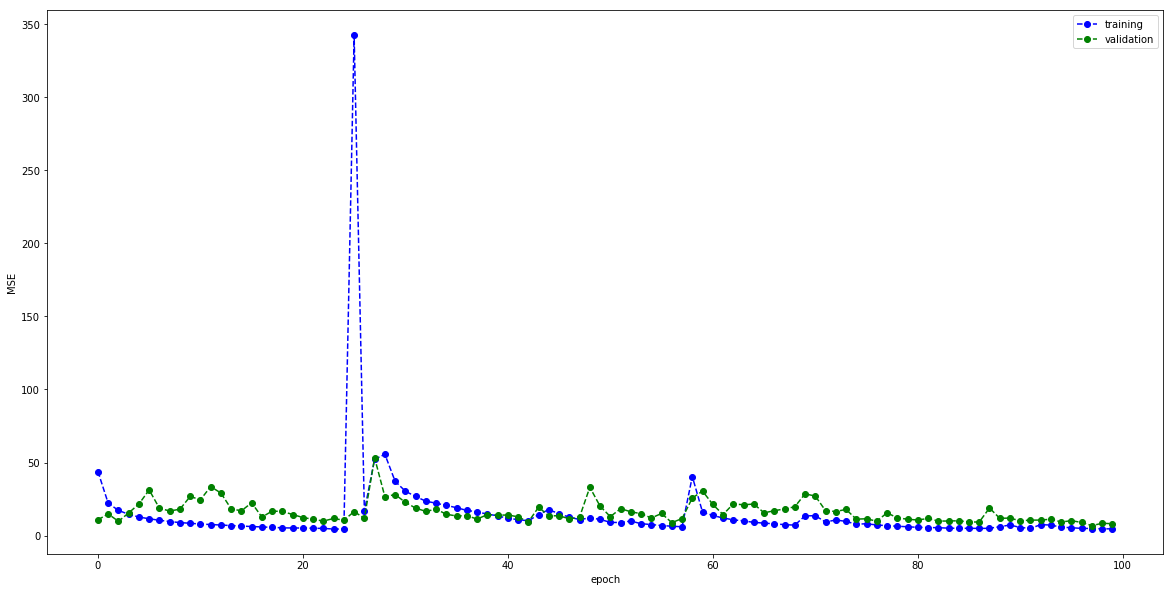

In [33]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'bo--')
plt.plot(history['val_loss'], 'go--')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [34]:
weights = os.path.join(RUN, "weights.180-2.42.hdf5") 
model = build_model(HEIGHT, WIDTH, CHANNEL, lr=0.0005)
model.load_weights(weights)

In [35]:
#Let's load the entire training video and evaluate the MSE on it
train_meta = pd.read_csv(TRAIN_FLOW_META_PATH)

In [36]:
train_meta.head()

,flow_path,speed
0,/floyd/home/data/prepared-data/flow_train_imgs...,28.105569
1,/floyd/home/data/prepared-data/flow_train_imgs...,28.106048
2,/floyd/home/data/prepared-data/flow_train_imgs...,28.118466
3,/floyd/home/data/prepared-data/flow_train_imgs...,28.119823
4,/floyd/home/data/prepared-data/flow_train_imgs...,28.098907


In [37]:
def predict(frame):
    for idx in tqdm(range(0, len(frame))):
        row = frame.iloc[[idx]].reset_index()
        flow = cv2.imread(row['flow_path'].values[0])
        flow = cv2.resize(flow, SIZE, interpolation=cv2.INTER_AREA)
        #drop useless channel
        flow = flow[:,:,[0,2]]
        #normalize
        flow = flow / 127.5
        speed = model.predict(np.array([flow]))
        frame.loc[[idx], 'predicted_speed'] = speed[0]

In [38]:
predict(train_meta)

100%|██████████| 20399/20399 [01:33<00:00, 218.04it/s]


In [39]:
train_meta.head()

,flow_path,speed,predicted_speed
0,/floyd/home/data/prepared-data/flow_train_imgs...,28.105569,28.801285
1,/floyd/home/data/prepared-data/flow_train_imgs...,28.106048,28.471493
2,/floyd/home/data/prepared-data/flow_train_imgs...,28.118466,28.042524
3,/floyd/home/data/prepared-data/flow_train_imgs...,28.119823,28.132368
4,/floyd/home/data/prepared-data/flow_train_imgs...,28.098907,27.729979


In [40]:
train_meta["predicted_speed"].max()

29.53312110900879

In [41]:
#Clip the speed
train_meta.loc[train_meta["predicted_speed"] < 0] = 0

In [42]:
train_meta.tail()

,flow_path,speed,predicted_speed
20394,/floyd/home/data/prepared-data/flow_train_imgs...,2.346995,2.516121
20395,/floyd/home/data/prepared-data/flow_train_imgs...,2.309488,2.634795
20396,/floyd/home/data/prepared-data/flow_train_imgs...,2.291356,2.482063
20397,/floyd/home/data/prepared-data/flow_train_imgs...,2.276759,2.350871
20398,/floyd/home/data/prepared-data/flow_train_imgs...,2.233680,2.244441


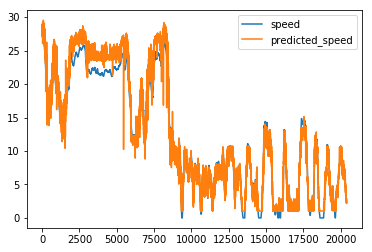

In [43]:
train_meta.plot()

In [44]:
# #rolling window
window_size = 30
train_meta['averaged_predicted_speed'] = train_meta['predicted_speed'].rolling(window_size, min_periods=1).mean()

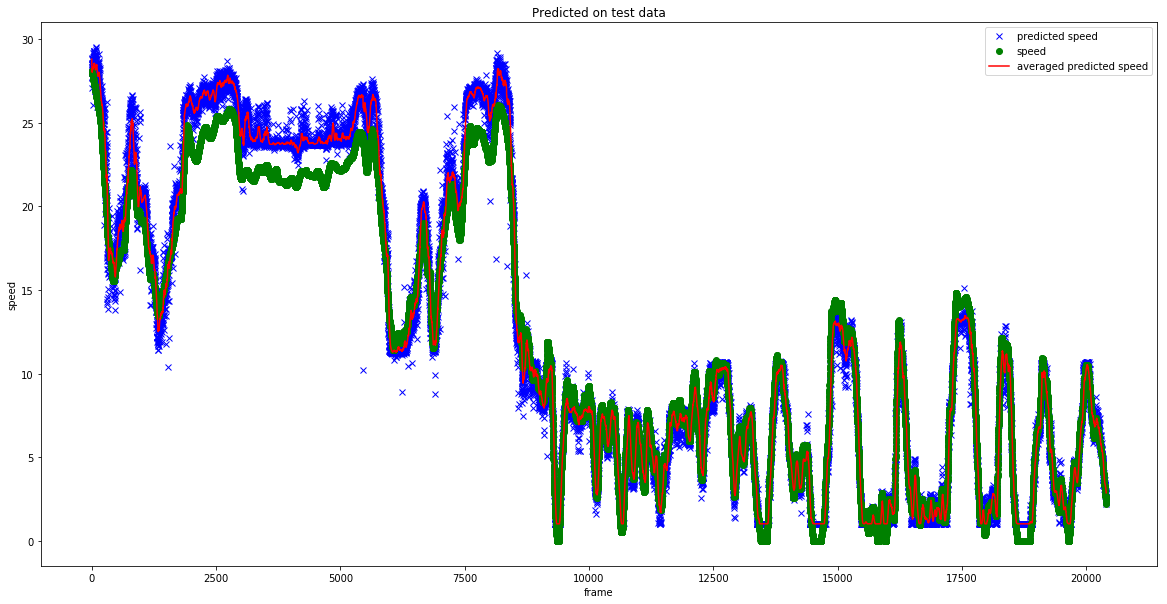

In [45]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(train_meta)), 
         train_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['speed']], 'go')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [46]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 2]))

2.081997042192431


In [47]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 3]))

1.9908269323311565


# Prediction

In [48]:
test_meta = pd.read_csv(TEST_FLOW_META_PATH)

In [49]:
test_meta.head()

,flow_path,speed
0,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0
1,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0
2,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0
3,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0
4,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0


In [50]:
predict(test_meta)

100%|██████████| 10797/10797 [00:55<00:00, 193.07it/s]


In [52]:
test_meta.head()

,flow_path,speed,predicted_speed
0,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,11.153272
1,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,10.830359
2,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,12.125954
3,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,12.049471
4,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,8.896699


In [53]:
test_meta["predicted_speed"].min()

1.0311354398727417

In [54]:
#Clip the speed
test_meta.loc[test_meta["predicted_speed"] < 0] = 0

In [55]:
#rolling window
window_size = 30
test_meta['averaged_predicted_speed'] = test_meta['predicted_speed'].rolling(window_size, min_periods=1).mean()

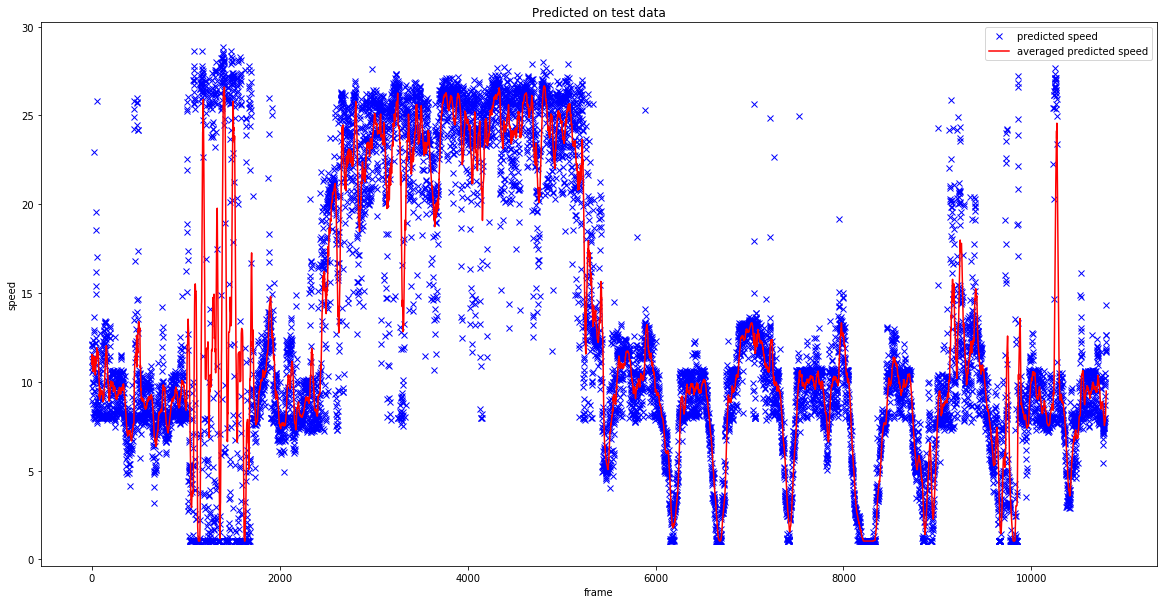

In [56]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(test_meta)), 
         test_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(test_meta)), 
         test_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [57]:
cv2.VideoWriter_fourcc(*'MJPG')
rec = cv2.VideoWriter('flow.avi',cv2.VideoWriter_fourcc(*'MJPG'),20,(300,300))
test_raw_meta = pd.read_csv(TEST_META_PATH)

In [58]:
len(test_raw_meta)

10798

In [59]:
print(len(test_meta))
test_meta.head()

10797


,flow_path,speed,predicted_speed,averaged_predicted_speed
0,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,11.153272,11.153272
1,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,10.830359,10.991816
2,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,12.125954,11.369862
3,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,12.049471,11.539764
4,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,8.896699,11.011151


In [60]:
#Add one more row to test_meta by copying the last row
last_speed = test_meta.iloc[[len(test_meta) - 1]]["averaged_predicted_speed"].values[0]
test_meta_extended = test_meta.append([{'averaged_predicted_speed': last_speed}], ignore_index=True)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [61]:
print(len(test_meta_extended))
test_meta_extended.tail()

10798


,flow_path,speed,predicted_speed,averaged_predicted_speed
10793,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,11.914282,8.854805
10794,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,12.645624,9.095021
10795,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,14.317555,9.326115
10796,/floyd/home/data/prepared-data/flow_test_imgs/...,0.0,11.671471,9.476167
10797,NaN,NaN,NaN,9.476167


In [62]:
#Write the result on disk
test_meta_extended.to_csv(TEST_TEXT_PATH, columns = ["averaged_predicted_speed"], index=False, header=False)

# Video with a prediction overlay

In [63]:
test_raw_meta.head()

,frame_path,frame_index,speed
0,/floyd/home/data/prepared-data/test_imgs/0.jpg,0,0
1,/floyd/home/data/prepared-data/test_imgs/1.jpg,1,0
2,/floyd/home/data/prepared-data/test_imgs/2.jpg,2,0
3,/floyd/home/data/prepared-data/test_imgs/3.jpg,3,0
4,/floyd/home/data/prepared-data/test_imgs/4.jpg,4,0


In [64]:
for index, row in tqdm(test_raw_meta.iterrows()):
    frame = cv2.imread(row["frame_path"])
    frame = cv2.resize(frame, (300, 300), interpolation=cv2.INTER_AREA)
    try:
        speed = test_meta.iloc[[index]]['averaged_predicted_speed'].values[0]
    except IndexError:
        speed = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,"Speed: " + str(speed),(5,15),font, 0.55,(255,255,255),2)
    rec.write(frame)
rec.release()

10798it [01:34, 113.71it/s]
